# Assignment 2: Household Labor Supply and Taxes

## 0: Setup and solve model

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd

from DynHouseholdLaborModel import *


# For plotting
import matplotlib.colors as mcolors
blue = mcolors.TABLEAU_COLORS['tab:blue']
orange = mcolors.TABLEAU_COLORS['tab:orange']
green = mcolors.TABLEAU_COLORS['tab:green']
red = mcolors.TABLEAU_COLORS['tab:red']


## 1: Change utility function

In [2]:
# model based on lecture code
model_lecture = DynHouseholdLaborModelClass(name='lecture', par={'lecture_model':True})
model_lecture.solve()
model_lecture.simulate()

In [3]:
# adjusted utility function
model_j = DynHouseholdLaborModelClass(name='joint')
model_j.solve()
model_j.simulate()

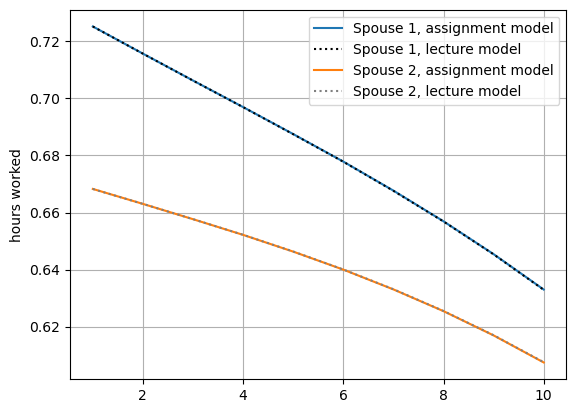

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

T = model_j.par.simT

# Spouse 1
ax.plot(range(1,T+1), model_j.sim.h1.mean(axis=0), 
        label='Spouse 1, assignment model',
        c=blue)
ax.plot(range(1,T+1), model_lecture.sim.h1.mean(axis=0), 
        label='Spouse 1, lecture model',
        c='black', 
        linestyle='dotted')

# Spouse 2
ax.plot(range(1,T+1), model_j.sim.h2.mean(axis=0), 
        label='Spouse 2, assignment model',
        c=orange)
ax.plot(range(1,T+1), model_lecture.sim.h2.mean(axis=0), 
        label='Spouse 2, lecture model',
        c='grey',
        linestyle='dotted')

ax.grid(True)
ax.legend()
ax.set_ylabel('hours worked')

fig.savefig('fig/assignment_vs_lecture.pdf')


## 3: Individual vs. joint taxation

In [5]:
model_s = DynHouseholdLaborModelClass(name='single', par={'joint_tax':False})
model_s.solve()
model_s.simulate()

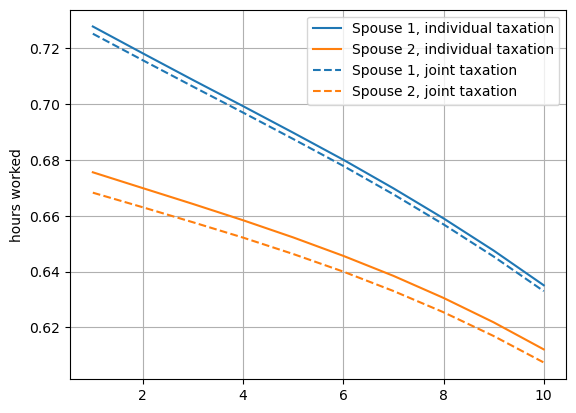

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(range(1,T+1), model_s.sim.h1.mean(axis=0),
        label='Spouse 1, individual taxation',
        c=blue)
ax.plot(range(1,T+1), model_s.sim.h2.mean(axis=0),
        label='Spouse 2, individual taxation',
        c=orange)

ax.plot(range(1,T+1), model_j.sim.h1.mean(axis=0),
        label='Spouse 1, joint taxation',
        c=blue,
        linestyle='--')
ax.plot(range(1,T+1), model_j.sim.h2.mean(axis=0),
        label='Spouse 2, joint taxation',
        c=orange,
        linestyle='--')

ax.grid(True)
ax.legend()
ax.set_ylabel('hours worked')

fig.savefig('fig/indiv_vs_joint.pdf')

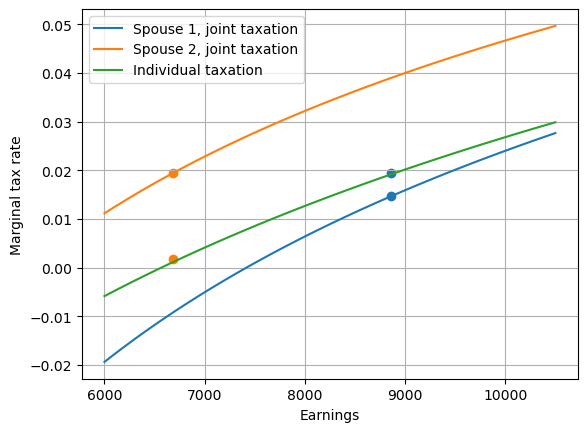

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

income = np.linspace(6000, 10500, 50)
inc1 = model_j.sim.income1[0,0]
inc2 = model_j.sim.income2[0,0]

incs1 = model_s.sim.income1[0,0]
incs2 = model_s.sim.income2[0,0]


# joint taxation
ax.plot(income, model_j.tax_func(income+inc2)/income, 
        label='Spouse 1, joint taxation')
ax.plot(income, model_j.tax_func(income+inc1)/income,
        label='Spouse 2, joint taxation')



# individual taxation
plt.plot(income, model_s.tax_func(income)/income,
         label='Individual taxation')

ax.scatter(inc1, model_j.tax_func(inc1+inc2)/(inc1))
ax.scatter(inc2, model_j.tax_func(inc1+inc2)/(inc2))

ax.scatter(inc1, model_s.tax_func(incs1)/(incs1),
           c=blue)
ax.scatter(inc2, model_s.tax_func(incs2)/(incs2),
           c=orange)


ax.grid(True)
ax.legend()
ax.set_xlabel('Earnings')
ax.set_ylabel('Marginal tax rate')

fig.savefig('fig/marg_tax.pdf')

## 4: Change in government budget

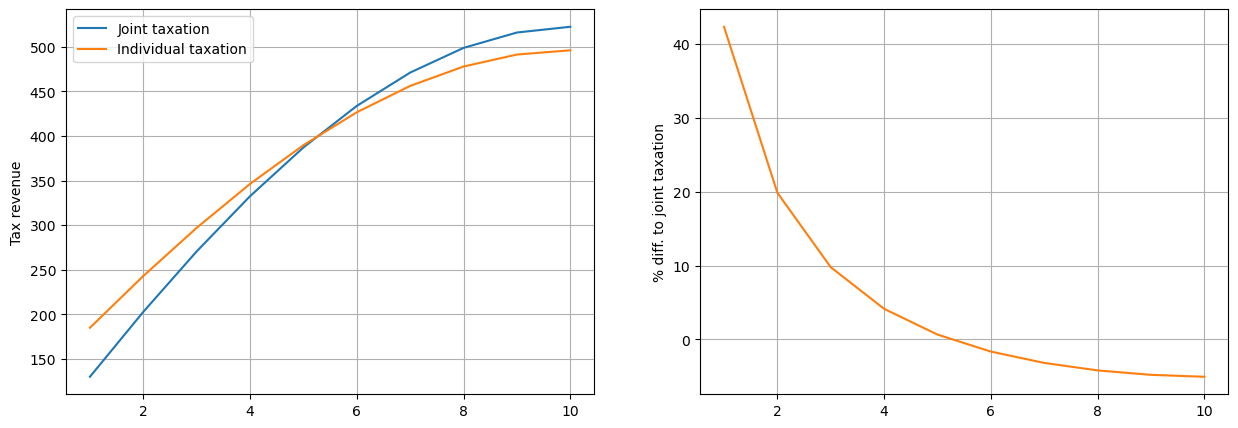

In [8]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1)
ax.plot(range(1,T+1), model_j.sim.T.mean(axis=0), label='Joint taxation')
ax.plot(range(1,T+1), model_s.sim.T.mean(axis=0), label='Individual taxation')
ax.legend()
ax.grid(True)
ax.set_ylabel('Tax revenue')

ax = fig.add_subplot(1,2,2)
yearly_surplus = 100*(model_s.sim.T.mean(axis=0) - model_j.sim.T.mean(axis=0))/model_j.sim.T.mean(axis=0)
ax.plot(range(1, T+1), yearly_surplus, c=orange)
ax.grid(True)
ax.set_ylabel('% diff. to joint taxation')

fig.savefig('fig/tax_rev.pdf')

## 5: Constant government budget

In [9]:
lambda_vec = np.linspace(1.7, 1.8, 10)
surp_vec = np.zeros(10)

for i, l in enumerate(lambda_vec):
    surp_vec[i] = model_j.gov_budget_change(l)

In [10]:
min=lambda_vec[surp_vec>0].min()
max=lambda_vec[surp_vec<0].max()

res = optimize.root_scalar(model_j.gov_budget_change, bracket=(min,max))
lambda_star = res.root # approx. 3 min runtime on my laptop

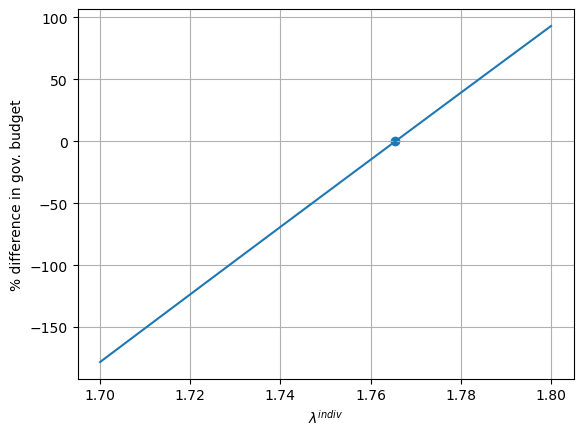

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(lambda_vec, surp_vec*100)
ax.scatter(lambda_star, 0)
ax.grid(True)
ax.set_xlabel('$\lambda^{indiv}$')
ax.set_ylabel('% difference in gov. budget')

fig.savefig('fig/const_govbud.pdf')

## 6: Optimal taxation scheme

In [12]:
model_s_neut = model_j.copy()
model_s_neut.par.tax_scale_s = lambda_star
model_s_neut.par.joint_tax = False
model_s_neut.solve()
model_s_neut.simulate()

In [13]:
from consav.linear_interp import interp_2d

def value_dif(model_j, model_s, k1,k2, a=0, resolve=False):

    if resolve:
        model_s.par.a = a
        model_s.solve()

    k_grid = model_s.par.k_grid

    V_joint = interp_2d(k_grid, k_grid, model_j.sol.V[0], k1, k2)
    V_single = interp_2d(k_grid, k_grid, model_s.sol.V[0], k1,k2)

    return V_single, V_joint, V_single-V_joint

In [14]:
# Value differences
Vdif_1 = value_dif(model_j, model_s_neut, 2,1)[2]
Vdif_2 = value_dif(model_j, model_s_neut, 8,8)[2]

In [15]:
#EV for k1,k2 = 2,0
obj = lambda a: value_dif(model_j, model_s_neut,0,2,a, resolve=True)[2]
res = optimize.root_scalar(obj, bracket=[-1000,0])
EV_1 = res.root
EV_1_pct = 100*EV_1/(model_s_neut.sim.income1[0,0] + model_s_neut.sim.income2[0,0])

In [16]:
#EV for k1,k2 = 8,8
obj = lambda a: value_dif(model_j, model_s_neut,8,8,a, resolve=True)[2]
res = optimize.root_scalar(obj, bracket=[-1000,0])
EV_2 = res.root
EV_2_pct = 100*EV_2/(model_s_neut.sim.income1[0,0] + model_s_neut.sim.income2[0,0])

In [17]:
res_dict = {'$V_0(\Omega_{indiv}) - V_0(\Omega_{joint})$': [Vdif_1, Vdif_2], 'EV (% of HH. income)': [EV_1_pct, EV_2_pct]}
table = pd.DataFrame(res_dict, index=['$(K_{1,0}, K_{2,0}) = (2,0)$', '$(K_{1,0}, K_{2,0}) = (8,8)$'])
print(table.style.format(precision=4, escape='latex').to_latex())


\begin{tabular}{lrr}
 & $V_0(\Omega_{indiv}) - V_0(\Omega_{joint})$ & EV (% of HH. income) \\
$(K_{1,0}, K_{2,0}) = (2,0)$ & 0.0001 & -0.0311 \\
$(K_{1,0}, K_{2,0}) = (8,8)$ & 0.0007 & -1.3576 \\
\end{tabular}

